# K-Nearest Neighbors Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor

## Load and Preprocess the Dataset

In [2]:
iris = load_iris(as_frame=True)
selected_samples = iris.target > 0
X = iris.data[['petal length (cm)', 'petal width (cm)']][selected_samples]
# Remove duplicates for better visualization
X = X.drop_duplicates()
y = iris.data['sepal length (cm)'][selected_samples][X.index]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Create the Algorithm from Scratch

In [3]:
class KNeighborsRegressorFromScratch:
    PLOT_X_LIM = [3.0, 6.9]
    PLOT_Y_LIM = [1.0, 2.5]
    PLOT_Z_LIM = [4.9, 7.9]
    COLORS = ['tab:blue']
    
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors
        self.X_train = None
        self.y_train = None
        self.X_train_len = None
        self.X_test_len = None
    
    def fit(self, x_train_param, y_train_param):
        self.X_train = x_train_param
        self.y_train = y_train_param
        
    def get_xs_transformed(self, x_test_param):
        x_train_transformed = np.vstack([X_train] * self.X_test_len)
        x_test_transformed = np.array(x_test_param).repeat(self.X_train_len, axis=0)
    
        return x_train_transformed, x_test_transformed
  
    def get_nearest_instance_indexes(self, x_train_transformed_param, x_test_transformed_param):
        differences = x_train_transformed_param - x_test_transformed_param
        distances = np.linalg.norm(differences, axis=1)
        split_distances = np.split(distances, self.X_test_len)

        return np.argpartition(split_distances, self.n_neighbors)[:, :self.n_neighbors]

    @staticmethod
    def get_predicted_targets(y_train_param, nearest_instance_indexes_param):
        nearest_instance_targets = np.array(y_train_param)[nearest_instance_indexes_param]
        
        return np.mean(nearest_instance_targets, axis=1)
 
    def animate(self, frame, frame_multiplier, ax, x_test_param, nearest_instances, 
                nearest_instance_targets, predicted_targets):
        prediction_nr = int(np.floor(frame / frame_multiplier) + 1)
        cut_x_test = x_test_param[:prediction_nr * frame_multiplier]
        cut_nearest_instances = nearest_instances[:prediction_nr * frame_multiplier]
        cut_nearest_instance_targets = nearest_instance_targets[:prediction_nr * frame_multiplier]
        cut_predicted_targets = predicted_targets[:prediction_nr * frame_multiplier]

        ax.clear()
        ax.view_init(azim=280 + frame, elev=30)
        ax.set_xlim(self.PLOT_X_LIM)
        ax.set_ylim(self.PLOT_Y_LIM)
        ax.set_zlim(self.PLOT_Z_LIM)
  
        # Draw training data points
        ax.scatter(self.X_train.iloc[:, 0], self.X_train.iloc[:, 1], self.y_train, 
                   c=self.COLORS[0], edgecolors='black', label="Training Instances")
    
        # Draw testing data points
        ax.scatter(cut_x_test[:, 0][:-frame_multiplier], cut_x_test[:, 1][:-frame_multiplier], 
                   cut_predicted_targets[:-frame_multiplier], c=self.COLORS[0], 
                   edgecolors='black', marker='s', label="Predicted Instances")
        
        last_x_test = cut_x_test[-1:][0]
        last_predicted_target = cut_predicted_targets[-1:][0]
  
        ax.scatter([last_x_test[0]], [last_x_test[1]], [last_predicted_target], c='red', 
                   edgecolors='black', marker='s')

        # Draw lines between training and testing data points
        last_nearest_instances = cut_nearest_instances[-1:][0]
        last_nearest_instance_targets = cut_nearest_instance_targets[-1:][0]

        for neighbor_instance_index in range(self.n_neighbors):
            nearest_instance = last_nearest_instances[neighbor_instance_index]
            nearest_instance_target = last_nearest_instance_targets[neighbor_instance_index]
            line_coordinates_x = [last_x_test[0], nearest_instance[0]]
            line_coordinates_y = [last_x_test[1], nearest_instance[1]]
            line_coordinates_z = [last_predicted_target, nearest_instance_target]

            ax.plot(line_coordinates_x, line_coordinates_y, line_coordinates_z, color='red')

        ax.legend()
        ax.set_axisbelow(True)
        ax.grid(color='grey')
        ax.set_title(f"#{prediction_nr} Prediction")
        ax.set_xlabel('petal length (cm)')
        ax.set_ylabel('petal width (cm)')
        ax.set_zlabel('sepal length (cm)')
        
    def predict(self, x_test_param, create_animation=False):
        self.X_train_len = len(X_train)
        self.X_test_len = len(X_test)        

        x_train_transformed, x_test_transformed = self.get_xs_transformed(x_test_param)
        nearest_instance_indexes = self.get_nearest_instance_indexes(x_train_transformed, 
                                                                     x_test_transformed)
        predicted_targets = self.get_predicted_targets(y_train, nearest_instance_indexes)
  
        if create_animation:
            if len(x_test_param.iloc[0]) != 2:
                raise Exception(("This K-Nearest Neighbors Regression animation implementation "
                                 "works only with two-dimensional features!"))
            
            frame_multiplier = 10
            frames = self.X_test_len * frame_multiplier
            nearest_instances = np.array(X_train)[nearest_instance_indexes]
            nearest_instance_targets = np.array(y_train)[nearest_instance_indexes]
            fig = plt.figure(figsize=plt.figaspect(1.))
            ax = fig.add_subplot(projection='3d')
            animation = FuncAnimation(fig, self.animate, frames, fargs=(
                frame_multiplier, ax, np.array(x_test_param).repeat(frame_multiplier, axis=0),
                nearest_instances.repeat(frame_multiplier, axis=0), 
                nearest_instance_targets.repeat(frame_multiplier, axis=0), 
                predicted_targets.repeat(frame_multiplier, axis=0)
            ))

            animation.save('k_nearest_neighbors_regression.gif', 
                           writer=PillowWriter(fps=15), dpi=200)
        
        return predicted_targets

## Create an Animation and Compare Implementations

0.13118000000000016

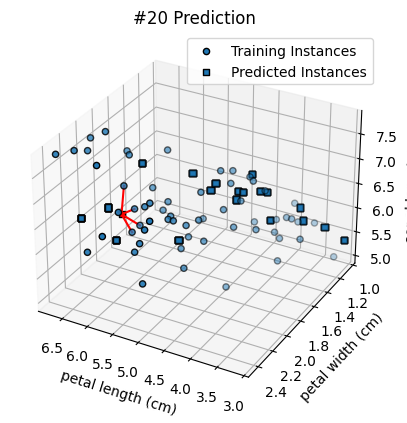

In [4]:
model_from_scratch = KNeighborsRegressorFromScratch()

model_from_scratch.fit(X_train, y_train)

y_pred = model_from_scratch.predict(X_test, create_animation=True)

mean_squared_error(y_test, y_pred)

In [5]:
model = KNeighborsRegressor()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mean_squared_error(y_test, y_pred)

0.13118000000000019